In [1]:
# Importing the libraries 
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import shap

In [2]:
df = pd.read_csv("online_shoppers_intention.csv")

In [3]:
# Changing the boolean datatypes into integer datatypes
df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [4]:
# Changing the other categorical variables into integer datatypes using ordinal encoding
# This transforms categorical value to numerical value in ordered sets through a dictionary

Month_dict = {'Feb' : 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

df['Month'] = df.Month.map(Month_dict)

VisitorType_dict = {'Other': 0, 'New_Visitor' : 1, 'Returning_Visitor': 2}

df['VisitorType'] = df.VisitorType.map(VisitorType_dict)

In [5]:
X = df.drop('Revenue', 1)
y = df['Revenue']

In [42]:
#mlp_model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5,), random_state=1)

mlp_model = MLPClassifier(random_state = 1)

In [24]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [43]:
mlp_scores = cross_val_score(mlp_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [44]:
print(np.mean(mlp_scores))

0.8716680183833472


In [45]:
y_pred_mlp = cross_val_predict(mlp_model, X, y, cv=5)

In [46]:
matrix = confusion_matrix(y, y_pred_mlp)
print(classification_report(y, y_pred_mlp))
print("Cohen's Kappa:", cohen_kappa_score(y, y_pred_mlp))
print("F1 score: ", f1_score(y, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     10422
           1       0.63      0.39      0.48      1908

    accuracy                           0.87     12330
   macro avg       0.76      0.68      0.71     12330
weighted avg       0.85      0.87      0.86     12330

Cohen's Kappa: 0.41488542844863896
F1 score:  0.484516129032258


The Multilayer Perceptron tends to predict class 0 rather than class 1, because of the imbalanced data.

In [47]:
# Use oversampling using SMOTE for the imbalanced dataset
columns = X.columns
os = SMOTE(random_state = 0)
os_data_X, os_data_y = os.fit_resample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Revenue'])

In [48]:
X_os=os_data_X
y_os=os_data_y['Revenue']

In [49]:
mlp_scores_os = cross_val_score(mlp_model, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [50]:
print(np.mean(mlp_scores_os))

0.8463495490509959


In [51]:
y_pred_mlp_os = cross_val_predict(mlp_model, X_os, y_os, cv=5)

In [52]:
matrix = confusion_matrix(y_os, y_pred_mlp_os)
print(classification_report(y_os, y_pred_mlp_os))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_mlp_os))
print("F1 score: ", f1_score(y_os, y_pred_mlp_os))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     10422
           1       0.83      0.81      0.82     10422

    accuracy                           0.82     20844
   macro avg       0.82      0.82      0.82     20844
weighted avg       0.82      0.82      0.82     20844

Cohen's Kappa: 0.6434465553636538
F1 score:  0.8201703445605885


The results show that the use of oversampling helps the Multilayer Perceptron model to predict the class 1 better. 

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X_os):
    # split data
    X_train, X_test = X_os.iloc[train_ix, :], X_os.iloc[test_ix, :]
    y_train, y_test = y_os[train_ix], y_os[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    # define the model
    model = MLPClassifier(random_state = 0)
    # define search space
    space = dict()
    space['hidden_layer_sizes'] = [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),
                                   (10,),(11,), (12,),(13,),(14,),(15,),(16,),
                                   (17,),(18,),(19,),(20,),(21,)]
    space['max_iter'] = [50, 100, 150]
    space['activation'] = ['tanh', 'relu']
    space['solver'] = ['sgd', 'adam']
    space['alpha'] = [0.0001, 0.05]
    space['learning_rate'] = ['constant', 'adaptive']    
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.888, est=0.886, cfg={'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (13,), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
>acc=0.872, est=0.885, cfg={'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (14,), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
>acc=0.876, est=0.888, cfg={'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (13,), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
>acc=0.889, est=0.886, cfg={'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (13,), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
>acc=0.879, est=0.887, cfg={'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (13,), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
Accuracy: 0.881 (0.007)


In [35]:
mlp_model_cv = MLPClassifier(activation = 'tanh', solver='adam', alpha= 0.0001, hidden_layer_sizes=(13,), learning_rate = 'constant', random_state=1)
mlp_scores_os_cv = cross_val_score(mlp_model_cv, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(np.mean(mlp_scores_os_cv))

0.884619480653214


In [36]:
y_pred_mlp_os_cv = cross_val_predict(mlp_model_cv, X_os, y_os, cv=5)

In [37]:
matrix = confusion_matrix(y_os, y_pred_mlp_os_cv)
print(classification_report(y_os, y_pred_mlp_os_cv))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_mlp_os_cv))
print("F1 score: ", f1_score(y_os, y_pred_mlp_os_cv))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86     10422
           1       0.84      0.92      0.88     10422

    accuracy                           0.87     20844
   macro avg       0.87      0.87      0.87     20844
weighted avg       0.87      0.87      0.87     20844

Cohen's Kappa: 0.7415083477259643
F1 score:  0.8764560212785473


For fold 1:
Accuracy: 0.9645739910313902
f-score: 0.9657118055555556
Results on the test set:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2230
           1       0.94      1.00      0.97      2230

    accuracy                           0.96      4460
   macro avg       0.97      0.96      0.96      4460
weighted avg       0.97      0.96      0.96      4460



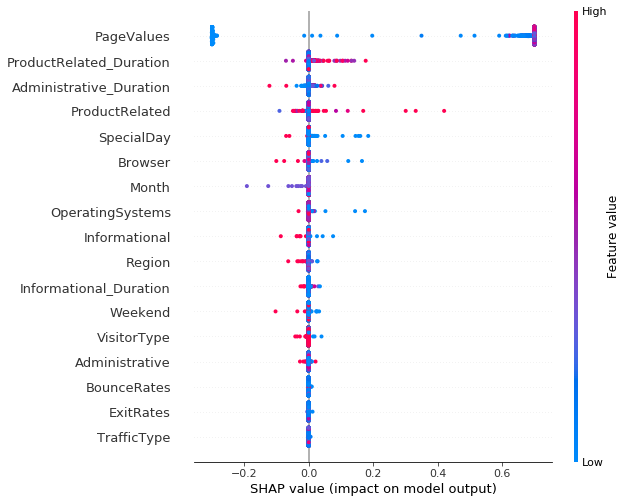

For fold 2:
Accuracy: 0.9314882032667876
f-score: 0.9358811040339703
Results on the test set:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93      2204
           1       0.88      1.00      0.94      2204

    accuracy                           0.93      4408
   macro avg       0.94      0.93      0.93      4408
weighted avg       0.94      0.93      0.93      4408



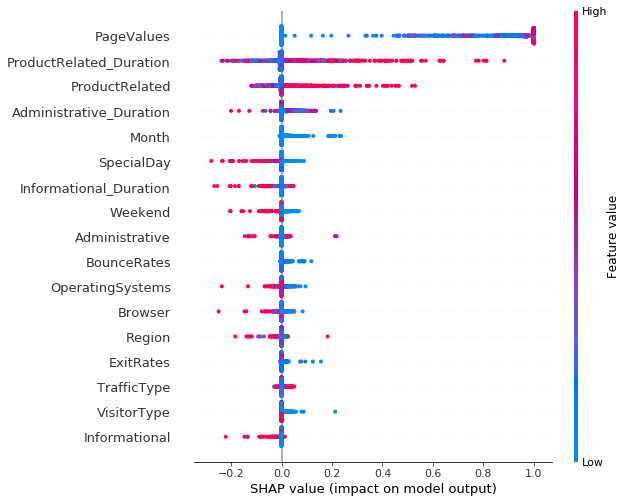

For fold 3:
Accuracy: 0.860611947547353
f-score: 0.8661380597014926
Results on the test set:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      2059
           1       0.83      0.90      0.87      2059

    accuracy                           0.86      4118
   macro avg       0.86      0.86      0.86      4118
weighted avg       0.86      0.86      0.86      4118



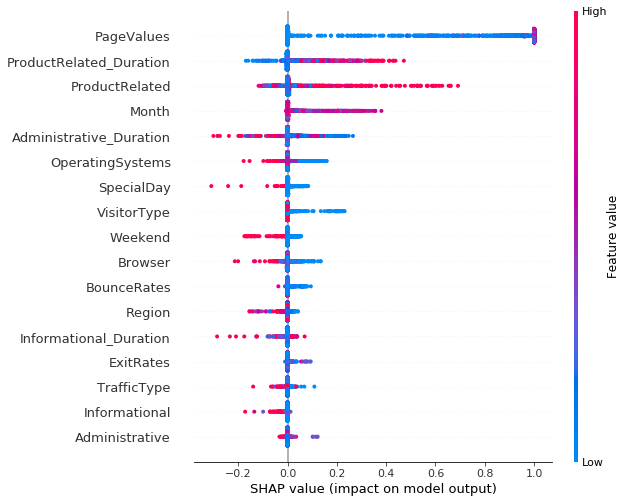

For fold 4:
Accuracy: 0.8582013285641288
f-score: 0.860236716192395
Results on the test set:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1957
           1       0.85      0.87      0.86      1957

    accuracy                           0.86      3914
   macro avg       0.86      0.86      0.86      3914
weighted avg       0.86      0.86      0.86      3914



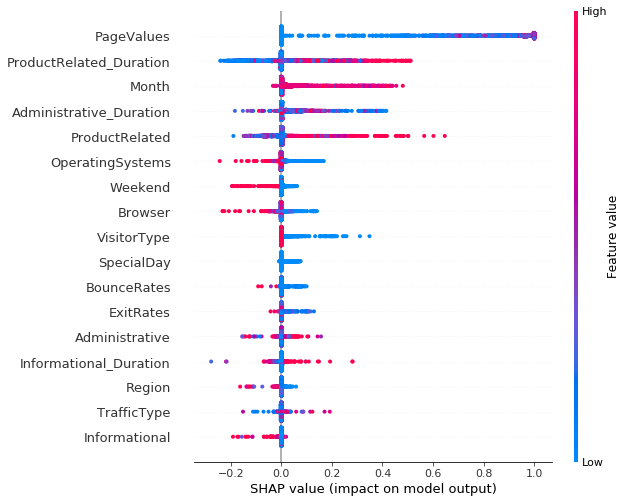

For fold 5:
Accuracy: 0.7743407707910751
f-score: 0.8011617515638964
Results on the test set:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      1972
           1       0.72      0.91      0.80      1972

    accuracy                           0.77      3944
   macro avg       0.80      0.77      0.77      3944
weighted avg       0.80      0.77      0.77      3944



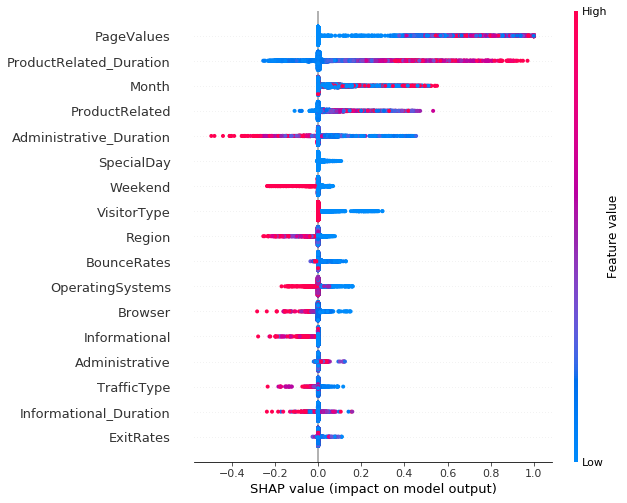

In [39]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]  # See comment on ravel and  y_train
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    X_test_oversampled, y_test_oversampled = sm.fit_resample(X_test, y_test)
    model = MLPClassifier(activation = 'tanh', solver='adam', alpha= 0.0001, hidden_layer_sizes=(13,), learning_rate = 'constant', random_state=1)  # Choose a model here
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred_oversampled = model.predict(X_test_oversampled)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test_oversampled, y_test_oversampled)}')
    print(f'f-score: {f1_score(y_test_oversampled, y_pred_oversampled)}')
    print('Results on the test set:')
    print(classification_report(y_test_oversampled, y_pred_oversampled))
    explainer = shap.KernelExplainer(model.predict, X_train_oversampled[:10])
    shap_values = explainer.shap_values(X_test_oversampled)
    shap.summary_plot(shap_values, X_test_oversampled)
    #print(X_test_oversampled.mean())

The accuracy score for the first fold is the highest, indicating that PageValues, ProductRelated_Duration, and Administrative_Duration are the most important features.

In [40]:
# Feature importance scores
shap_sum = (shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,0.312851
5,ProductRelated_Duration,0.115306
10,Month,0.0962254
4,ProductRelated,0.0584841
1,Administrative_Duration,0.0178145
9,SpecialDay,0.01433
15,VisitorType,0.0130462
6,BounceRates,0.00895706
11,OperatingSystems,0.00301805
0,Administrative,0.00297672


In [41]:
# Feature importance scores
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,0.312851
5,ProductRelated_Duration,0.146354
10,Month,0.0962254
4,ProductRelated,0.0597756
1,Administrative_Duration,0.0385893
9,SpecialDay,0.0143722
16,Weekend,0.0138072
15,VisitorType,0.0130462
13,Region,0.0112521
6,BounceRates,0.00919091
